# DL-Lab 6 - Implementación de GLoVe

Este lab contiene una implementación paso a paso de técnicas de optimización de entrenamiento utilizando embeddings de palabras (GLoVe). A continuación se presentan los pasos detallados y los bloques de código extraídos del notebook.

## Técnicas Cubiertas:

- Importación de librerías y fijación de semilla aleatoria
- Exploración y preprocesamiento de datos
- Tokenización y embeddings de palabras
- Construcción y entrenamiento de modelos de redes neuronales
- Ajuste de hiperparámetros y evaluación del modelo

### 1. Importación de Librerías

In [23]:
import pandas as pd
import numpy as np
import re
import os
import random
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

In [24]:
# Descargar recursos necesarios para NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### 2. Fijación de la Semilla Aleatoria

In [25]:
SEED_VALUE = 42
tf.random.set_seed(SEED_VALUE)  # Semilla de TensorFlow
np.random.seed(SEED_VALUE)  # Semilla de NumPy
random.seed(SEED_VALUE)  # Semilla de Python
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)  # Semilla para hash de Python para reproducibilidad

### 3. Exploración de Datos

In [26]:
file_path = 'IMDB Dataset.csv'
try:
    # Intentar cargar el archivo CSV
    df = pd.read_csv(file_path)
    df.head()
except FileNotFoundError:
    print(f"Error: El archivo {file_path} no fue encontrado.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

In [27]:
# Mostrar la cantidad de valores nulos por columna
print("Cantidad de valores nulos por columna:")
print(df.isnull().sum())

Cantidad de valores nulos por columna:
review       0
sentiment    0
dtype: int64


### 4. Preprocesamiento y Limpieza

In [28]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [29]:
def preprocess_text(text):
    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)
    # Convertir el texto a minúsculas
    text = text.lower()
    # Expandir contracciones comunes para un mejor análisis
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Eliminar espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenizar el texto y eliminar stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lematizar las palabras para reducirlas a su forma base
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return ' '.join(words)

In [30]:
# Aplicar la función a las reseñas
df['review'] = df['review'].apply(preprocess_text)

In [31]:
# Filtrar solo las clases 'Positive' y 'Negative'
df_filtered = df[df['sentiment'].isin(['positive', 'negative'])]

In [32]:
# Mapear la columna 'sentiment' a valores numéricos
df_filtered['sentiment'] = df_filtered['sentiment'].map({'positive': 1, 'negative': 0})

In [33]:
df_filtered.head()

,review,sentiment
0,one reviewers mention watch oz episode hook ri...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stun fi...,1


In [34]:
# Guardar el dataset limpiado a un archivo CSV
cleaned_file_path = "IMDB_Dataset_Cleaned.csv"
df_filtered.to_csv(cleaned_file_path, index=False)

### 5. Tokenización
- Tokenizando el texto y convirtiéndolo en secuencias.

In [45]:
df = pd.read_csv('IMDB_Dataset_Cleaned.csv')
df.head()

,review,sentiment
0,one reviewers mention watch oz episode hook ri...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stun fi...,1


In [46]:
embedding_dim = 100
max_words = 10000  # Número máximo de palabras a mantener, basado en la frecuencia de las palabras

In [47]:
# Crear un tokenizador para convertir las palabras en índices numéricos
tokenizer = Tokenizer(num_words=max_words)  # Limitar a las 10,000 palabras más frecuentes
tokenizer.fit_on_texts(df['review'])  # Ajustar el tokenizador a las reseñas
# Convertir las reseñas en secuencias de índices
sequences = tokenizer.texts_to_sequences(df['review'])
# Encontrar la longitud máxima de las secuencias para usar en el padding
max_len = max(len(seq) for seq in sequences)
# Rellenar las secuencias para que todas tengan la misma longitud
data = pad_sequences(sequences, maxlen=max_len)

### 6. Embeddings de Palabras con GLoVe
- Cargando los embeddings de GloVe para crear una matriz de embeddings.

In [48]:
glove_path = 'glove.6B/glove.6B.100d.txt'

In [49]:
embeddings_index = {}
# Cargar los embeddings de GloVe desde el archivo
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # La palabra
        coefs = np.asarray(values[1:], dtype='float32')  # El vector de embeddings
        embeddings_index[word] = coefs  # Añadir al diccionario

# Crear la matriz de embeddings con las palabras del tokenizador
num_words = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [50]:
embedding_matrix.shape

(10000, 100)

### 7. Construcción y Evaluación del Modelo
- Definiendo un modelo de red neuronal simple y entrenándolo.

In [58]:
# Preparar las etiquetas
labels = df['sentiment'].values

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=SEED_VALUE)

In [72]:
# Definir el modelo de red neuronal secuencial
model = Sequential()
# Añadir una capa de embedding que utiliza la matriz de embeddings preentrenada
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    input_length=max_len,
                    weights=[embedding_matrix],  # Usar la matriz de embeddings preentrenada
                    trainable=False))  # No entrenar los embeddings
# Añadir una capa GlobalAveragePooling para reducir dimensionalidad y prevenir el sobreajuste
model.add(GlobalAveragePooling1D())
# Añadir una capa densa para la salida (clasificación binaria)
model.add(Dense(1, activation='sigmoid'))

In [73]:
# Compilar el modelo con el optimizador Adam y la función de pérdida de entropía cruzada binaria
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [74]:
# Entrenar el modelo con los datos de entrenamiento y validación
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5749 - loss: 0.6892 - val_accuracy: 0.6774 - val_loss: 0.6764
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6714 - loss: 0.6739 - val_accuracy: 0.6994 - val_loss: 0.6627
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6916 - loss: 0.6612 - val_accuracy: 0.7070 - val_loss: 0.6510
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6994 - loss: 0.6504 - val_accuracy: 0.7121 - val_loss: 0.6409
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7054 - loss: 0.6410 - val_accuracy: 0.7137 - val_loss: 0.6321
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7078 - loss: 0.6329 - val_accuracy: 0.7159 - val_loss: 0.6245
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7099 - loss: 0.6258 - val_accuracy: 0.7182 - val_loss: 0.6178
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7132 - loss: 0.6195 -

In [75]:
# Función para graficar valores de entrenamiento y validación
def graficar_entrenamiento(histories, labels, colors):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for history, label, color in zip(histories, labels, colors):
        axes[0].plot(history.history['accuracy'], color=color, linestyle='-', label=f'{label} Train')
        axes[0].plot(history.history['val_accuracy'], color=color, linestyle='--', label=f'{label} Validation')
    axes[0].set_title('Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    for history, label, color in zip(histories, labels, colors):
        axes[1].plot(history.history['loss'], color=color, linestyle='-', label=f'{label} Train')
        axes[1].plot(history.history['val_loss'], color=color, linestyle='--', label=f'{label} Validation')
    axes[1].set_title('Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [76]:
# Método para probar el modelo con una nueva reseña
def probar_modelo(reseña):
    reseña_procesada = preprocess_text(reseña)
    secuencia = tokenizer.texts_to_sequences([reseña_procesada])
    secuencia_padded = tf.keras.preprocessing.sequence.pad_sequences(secuencia, maxlen=max_len)
    prediccion = model.predict(secuencia_padded)
    if prediccion >= 0.5:
        print("Reseña positiva")
    else:
        print("Reseña negativa")

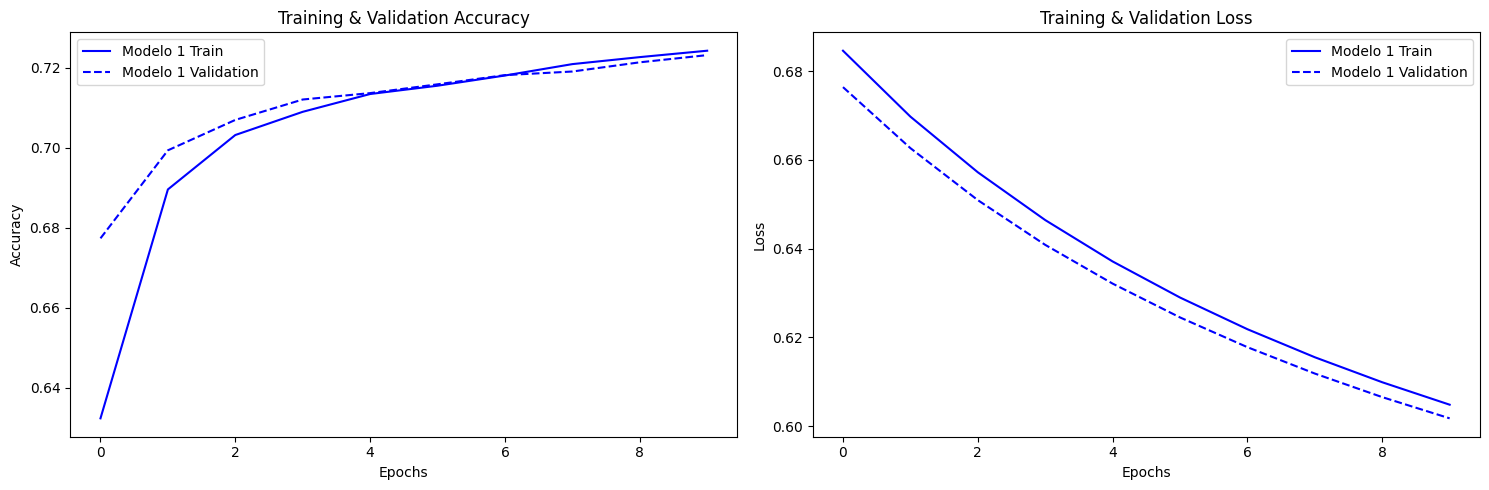

In [77]:
# Graficar resultados del modelo
graficar_entrenamiento([history], ['Modelo 1'], ['blue'])

In [78]:
# Probar el modelo con una reseña
probar_modelo("I love this movie")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Reseña positiva


### 8. Ajuste de Hiperparámetros
- Experimentando con diferentes tamaños de batch e introduciendo dropout para reducir el sobreajuste.

In [79]:
# Diferentes tamaños de batch para evaluar el impacto en el rendimiento
history_16 = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7201 - loss: 0.6035 - val_accuracy: 0.7267 - val_loss: 0.5949
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7230 - loss: 0.5973 - val_accuracy: 0.7290 - val_loss: 0.5894
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7255 - loss: 0.5920 - val_accuracy: 0.7319 - val_loss: 0.5845
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7277 - loss: 0.5874 - val_accuracy: 0.7328 - val_loss: 0.5802
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7301 - loss: 0.5832 - val_accuracy: 0.7359 - val_loss: 0.5763
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7321 - loss: 0.5795 - val_accuracy: 0.7376 - val_loss: 0.5727
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7342 - loss: 0.5760 - val_accuracy: 0.7390 - val_loss: 0.5694
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7370 - loss

In [80]:


# Añadiendo dropout para reducir el sobreajuste
model_dropout = Sequential()
# Añadir una capa de embedding que utiliza la matriz de embeddings preentrenada
model_dropout.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))  # Permitir que se entrene
# Añadir una capa GlobalAveragePooling para reducir dimensionalidad y prevenir el sobreajuste
model_dropout.add(GlobalAveragePooling1D())
# Añadir una capa de Dropout para reducir el sobreajuste
model_dropout.add(Dropout(0.2))
# Añadir una capa densa para la salida
model_dropout.add(Dense(1, activation='sigmoid'))
# Compilar el modelo
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con dropout
# El Dropout ayuda a prevenir el sobreajuste al apagar aleatoriamente algunas neuronas durante el entrenamiento
dropout_history = model_dropout.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 90ms/step - accuracy: 0.5185 - loss: 0.6932 - val_accuracy: 0.5893 - val_loss: 0.6679
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 100s 80ms/step - accuracy: 0.6094 - loss: 0.6615 - val_accuracy: 0.7622 - val_loss: 0.5997
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.6873 - loss: 0.5974 - val_accuracy: 0.8173 - val_loss: 0.5110
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 110s 88ms/step - accuracy: 0.7525 - loss: 0.5197 - val_accuracy: 0.7175 - val_loss: 0.4976
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 81ms/step - accuracy: 0.7908 - loss: 0.4590 - val_accuracy: 0.7616 - val_loss: 0.4531
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 86ms/step - accuracy: 0.8175 - loss: 0.4164 - val_accuracy: 0.8096 - val_loss: 0.4064
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 100s 80ms/step - accuracy: 0.8357 - loss: 0.3864 - val_accuracy: 0.7972 - val_loss: 0.4069
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 110s 87ms/step - accuracy: 